In [8]:
# 필요한 라이브러리 임포트
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 환경변수 로드
import os
from dotenv import load_dotenv
load_dotenv()

print("=== PyTorch 로지스틱 회귀 튜토리얼 ===")


=== PyTorch 로지스틱 회귀 튜토리얼 ===


In [9]:
# 데이터 로드
print("1. 데이터 로드 중...")

# 타이타닉 데이터셋 URL
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"

try:
    # 데이터 로드
    df = pd.read_csv(url)
    print(f"데이터 로드 완료! 데이터 크기: {df.shape}")
    print(f"컬럼: {list(df.columns)}")
    
    # 기본 정보 출력
    print("\n데이터 미리보기:")
    print(df.head())
    print("\n데이터 정보:")
    print(df.info())
    print(f"\n생존률: {df['Survived'].mean():.2%}")
    
except Exception as e:
    print(f"데이터 로드 실패: {e}")
    # 백업: 간단한 합성 데이터 생성
    print("합성 데이터를 생성합니다...")
    np.random.seed(42)
    n_samples = 800
    df = pd.DataFrame({
        'Age': np.random.normal(30, 12, n_samples),
        'Fare': np.random.exponential(20, n_samples),
        'Pclass': np.random.choice([1, 2, 3], n_samples, p=[0.2, 0.3, 0.5]),
        'Sex_male': np.random.choice([0, 1], n_samples),
        'Survived': np.random.choice([0, 1], n_samples, p=[0.6, 0.4])
    })


1. 데이터 로드 중...
데이터 로드 완료! 데이터 크기: (891, 12)
컬럼: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

데이터 미리보기:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   

In [10]:
# 데이터 전처리
print("\n2. 데이터 전처리...")

# 필요한 피처 선택 및 전처리
if 'Sex' in df.columns:
    # 성별을 숫자로 변환 (male=1, female=0)
    df['Sex_male'] = (df['Sex'] == 'male').astype(int)

# 사용할 피처 선택
features = ['Pclass', 'Sex_male', 'Age', 'Fare']
available_features = [f for f in features if f in df.columns]

print(f"사용 가능한 피처: {available_features}")

# 결측값 처리
for feature in available_features:
    if df[feature].isnull().sum() > 0:
        df[feature].fillna(df[feature].median(), inplace=True)

# 특성과 타겟 분리
X = df[available_features].values
y = df['Survived'].values

print(f"입력 데이터 형태: {X.shape}")
print(f"타겟 데이터 형태: {y.shape}")



2. 데이터 전처리...
사용 가능한 피처: ['Pclass', 'Sex_male', 'Age', 'Fare']
입력 데이터 형태: (891, 4)
타겟 데이터 형태: (891,)


/var/folders/hw/9m3g7fvn4_l3rp2y473km9sm0000gn/T/ipykernel_68910/2299287526.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[feature].fillna(df[feature].median(), inplace=True)


In [11]:
# 데이터 분할 및 정규화
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 특성 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PyTorch 텐서로 변환
X_train_tensor = torch.FloatTensor(X_train_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_train_tensor = torch.FloatTensor(y_train)
y_test_tensor = torch.FloatTensor(y_test)

print(f"훈련 데이터: {X_train_tensor.shape}")
print(f"테스트 데이터: {X_test_tensor.shape}")


훈련 데이터: torch.Size([712, 4])
테스트 데이터: torch.Size([179, 4])


In [12]:
print("3. 로지스틱 회귀 모델 정의...")

class LogisticRegression(nn.Module):
    """
    간단한 로지스틱 회귀 모델
    
    로지스틱 회귀는 선형 결합 후 시그모이드 함수를 적용하여
    이진 분류를 수행하는 모델입니다.
    """
    
    def __init__(self, input_size):
        super(LogisticRegression, self).__init__()
        # 선형 레이어: 입력 특성들을 하나의 값으로 변환
        self.linear = nn.Linear(input_size, 1)
        # 시그모이드 함수: 0과 1 사이의 확률값으로 변환
        self.sigmoid = nn.Sigmoid()

        # --- 파라미터 초기화 (Parameter Initialization) ---
        # 신경망의 가중치와 편향을 적절히 초기화하는 것은 학습 안정성과 수렴 속도에 중요합니다.
        # 잘못된 초기화는 기울기 소실(vanishing gradients)이나 폭주(exploding gradients) 문제를 야기할 수 있습니다.
        #
        # PyTorch의 `nn.Linear`는 기본적으로 Kaiming He 초기화(ReLU와 함께 사용 시 적합)나 Xavier/Glorot 초기화(Sigmoid/Tanh와 함께 사용 시 적합)를 사용합니다.
        # 여기서는 명시적으로 Xavier Uniform 초기화를 적용하여 선형 레이어의 가중치를 초기화합니다.
        # 이는 Sigmoid 활성화 함수와 잘 어울립니다. 편향은 0으로 초기화합니다.
        nn.init.xavier_uniform_(self.linear.weight)
        if self.linear.bias is not None:
            nn.init.zeros_(self.linear.bias)
        # --------------------------------------------------
    
    def forward(self, x):
        # 선형 변환 후 시그모이드 적용
        out = self.linear(x)
        out = self.sigmoid(out)
        return out

# 모델 인스턴스 생성
input_size = X_train_tensor.shape[1]
model = LogisticRegression(input_size)

# GPU 사용 가능 시 디바이스 설정
# MPS (Metal Performance Shaders)는 Apple Silicon Mac에서 GPU 가속을 제공합니다.
# 이 코드는 MPS를 사용할 수 있다면 'mps' 디바이스를, 그렇지 않다면 'cpu' 디바이스를 선택합니다.
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model.to(device)

# 텐서들을 모델과 같은 디바이스로 이동
X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

print(f"모델 구조:")
print(model)
print(f"\n모델 파라미터:")
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")
print(f"\n디바이스: {device}")
print(f"텐서 디바이스: {X_train_tensor.device}")


3. 로지스틱 회귀 모델 정의...
모델 구조:
LogisticRegression(
  (linear): Linear(in_features=4, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

모델 파라미터:
linear.weight: torch.Size([1, 4])
linear.bias: torch.Size([1])

디바이스: mps
텐서 디바이스: mps:0


In [13]:
print("4. 모델 훈련 설정...")

# 손실 함수: 이진 교차 엔트로피 (Binary Cross Entropy)
criterion = nn.BCELoss()

# 옵티마이저: Adam
# `weight_decay` (L2 정규화): 과적합(overfitting)을 방지하는 정규화 기법 중 하나입니다.
# L2 정규화는 모델의 가중치(weights)가 너무 커지는 것을 제어하여 모델의 복잡도를 줄입니다.
# 손실 함수에 가중치 제곱합의 일정 비율을 더함으로써 큰 가중치에 패널티를 부여합니다.
# `weight_decay=0.001`은 이 패널티의 강도를 조절하는 하이퍼파라미터입니다.
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)

# 훈련 설정
num_epochs = 1000
losses = []

print(f"훈련 설정:")
print(f"- 에포크 수: {num_epochs}")
print(f"- 학습률: {optimizer.param_groups[0]['lr']}")
print(f"- 손실 함수: {criterion.__class__.__name__}")
print(f"- 옵티마이저: {optimizer.__class__.__name__}")
print(f"- L2 정규화 (Weight Decay): {optimizer.param_groups[0].get('weight_decay', 'N/A')}")


4. 모델 훈련 설정...
훈련 설정:
- 에포크 수: 1000
- 학습률: 0.01
- 손실 함수: BCELoss
- 옵티마이저: Adam
- L2 정규화 (Weight Decay): 0.001


In [14]:
print("5. 모델 훈련 시작...")

model.train()  # 훈련 모드 설정

for epoch in range(num_epochs):
    # 순전파 (Forward pass)
    outputs = model(X_train_tensor)
    loss = criterion(outputs.squeeze(), y_train_tensor)
    
    # 역전파 (Backward pass)
    optimizer.zero_grad()  # 기울기 초기화
    loss.backward()        # 기울기 계산
    optimizer.step()       # 파라미터 업데이트
    
    # 손실 기록
    losses.append(loss.item())
    
    # 진행 상황 출력
    if (epoch + 1) % 100 == 0:
        print(f'에포크 [{epoch+1}/{num_epochs}], 손실: {loss.item():.4f}')

print("훈련 완료!")


5. 모델 훈련 시작...
에포크 [100/1000], 손실: 0.4718
에포크 [200/1000], 손실: 0.4500
에포크 [300/1000], 손실: 0.4464
에포크 [400/1000], 손실: 0.4460
에포크 [500/1000], 손실: 0.4459
에포크 [600/1000], 손실: 0.4459
에포크 [700/1000], 손실: 0.4459
에포크 [800/1000], 손실: 0.4459
에포크 [900/1000], 손실: 0.4459
에포크 [1000/1000], 손실: 0.4459
훈련 완료!


In [16]:
print("6. 모델 평가...")

model.eval()  # 평가 모드 설정

with torch.no_grad():  # 기울기 계산 비활성화
    # 훈련 데이터 예측
    train_outputs = model(X_train_tensor)
    train_predictions = (train_outputs.squeeze() > 0.5).float()
    train_accuracy = accuracy_score(y_train_tensor.cpu().numpy(), train_predictions.cpu().numpy())
    
    # 테스트 데이터 예측
    test_outputs = model(X_test_tensor)
    test_predictions = (test_outputs.squeeze() > 0.5).float()
    test_accuracy = accuracy_score(y_test_tensor.cpu().numpy(), test_predictions.cpu().numpy())

print(f"훈련 정확도: {train_accuracy:.4f}")
print(f"테스트 정확도: {test_accuracy:.4f}")

# 분류 보고서
print(f"\n분류 보고서:")
print(classification_report(y_test_tensor.cpu().numpy(), test_predictions.cpu().numpy()))


6. 모델 평가...
훈련 정확도: 0.8006
테스트 정확도: 0.7933

분류 보고서:
              precision    recall  f1-score   support

         0.0       0.82      0.85      0.84       110
         1.0       0.75      0.70      0.72        69

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



/Users/jaesolshin/Documents/GitHub/pytorch_learn/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jaesolshin/Documents/GitHub/pytorch_learn/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jaesolshin/Documents/GitHub/pytorch_learn/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54984 (\N{HANGUL SYLLABLE HUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jaesolshin/Documents/GitHub/pytorch_learn/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47144 (\N{HANGUL SYLLABLE RYEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jaesolshin/Document

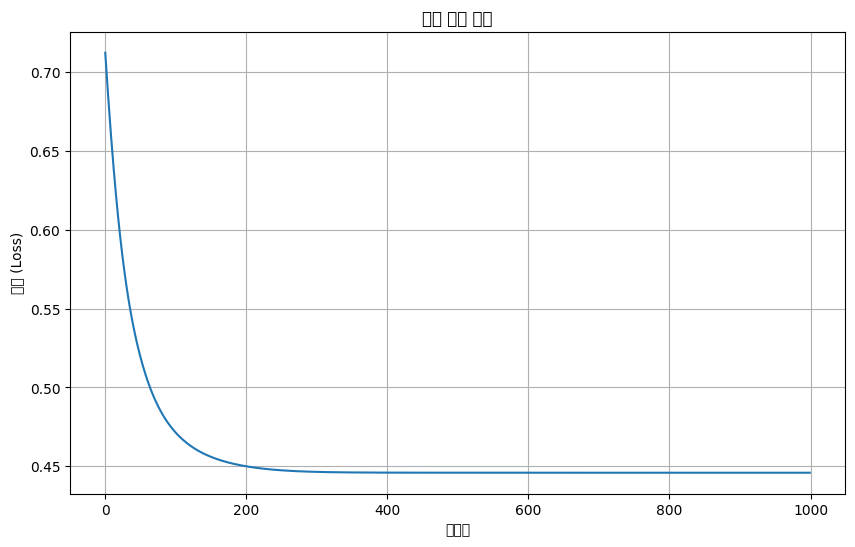


예측 확률 샘플:
실제 값 | 예측 확률 | 예측 값
------------------------------
   0    |   0.101    |    0
   0    |   0.053    |    0
   1    |   0.105    |    0
   0    |   0.058    |    0
   1    |   0.566    |    1
   1    |   0.499    |    0
   1    |   0.757    |    1
   0    |   0.352    |    0
   0    |   0.343    |    0
   0    |   0.201    |    0

모델 파라미터 (가중치):
linear.weight: tensor([-0.9547, -1.2459, -0.4430,  0.0538], device='mps:0')
linear.bias: -0.6504554748535156


In [17]:
# 손실 곡선 시각화
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('훈련 손실 곡선')
plt.xlabel('에포크')
plt.ylabel('손실 (Loss)')
plt.grid(True)
plt.show()

# 몇 개 샘플에 대한 예측 확률 출력
print("\n예측 확률 샘플:")
print("실제 값 | 예측 확률 | 예측 값")
print("-" * 30)
for i in range(10):
    actual = int(y_test_tensor[i].cpu().item())
    prob = test_outputs[i].cpu().item()
    predicted = int(test_predictions[i].cpu().item())
    print(f"   {actual}    |   {prob:.3f}    |    {predicted}")

print(f"\n모델 파라미터 (가중치):")
for name, param in model.named_parameters():
    print(f"{name}: {param.data.squeeze()}")
